# Log Anomaly Detection with One-Class SVM
This notebook detects anomalies in log data using One-Class SVM

In [11]:

import pandas as pd

# Load dataset
file_path = './Linux_2k.log_structured.csv'
df = pd.read_csv(file_path)
df.head()


,LineId,Month,Date,Time,Level,Component,PID,Content,EventId,EventTemplate
0,1,Jun,14,15:16:01,combo,sshd(pam_unix),19939.0,authentication failure; logname= uid=0 euid=0 ...,E16,authentication failure; logname= uid=0 euid=0 ...
1,2,Jun,14,15:16:02,combo,sshd(pam_unix),19937.0,check pass; user unknown,E27,check pass; user unknown
2,3,Jun,14,15:16:02,combo,sshd(pam_unix),19937.0,authentication failure; logname= uid=0 euid=0 ...,E16,authentication failure; logname= uid=0 euid=0 ...
3,4,Jun,15,02:04:59,combo,sshd(pam_unix),20882.0,authentication failure; logname= uid=0 euid=0 ...,E18,authentication failure; logname= uid=0 euid=0 ...
4,5,Jun,15,02:04:59,combo,sshd(pam_unix),20884.0,authentication failure; logname= uid=0 euid=0 ...,E18,authentication failure; logname= uid=0 euid=0 ...


## Preprocessing: Convert Text to Numerical Features

In [12]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Convert EventId into numerical labels
label_encoder = LabelEncoder()
df["EventId_encoded"] = label_encoder.fit_transform(df["EventId"])

# TF-IDF vectorization of log content
vectorizer = TfidfVectorizer(max_features=500)  
tfidf_matrix = vectorizer.fit_transform(df["Content"])

# Combine encoded EventId and TF-IDF features
X = np.hstack((df["EventId_encoded"].values.reshape(-1, 1), tfidf_matrix.toarray()))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape


(2000, 501)

## Apply One Class SVM for Anomaly Detection

In [13]:
from sklearn.svm import OneClassSVM

# Apply One-Class SVM
svm = OneClassSVM(nu=0.10, kernel="rbf", gamma="scale")  # 'nu' controls anomaly fraction
df["Anomaly_SVM"] = svm.fit_predict(X_scaled)

# One-Class SVM labels anomalies as -1, normal points as 1
num_anomalies_svm = (df["Anomaly_SVM"] == -1).sum()
print(f"One-Class SVM detected: {num_anomalies_svm} anomalies")


One-Class SVM detected: 291 anomalies


## Visualizing Anomalies

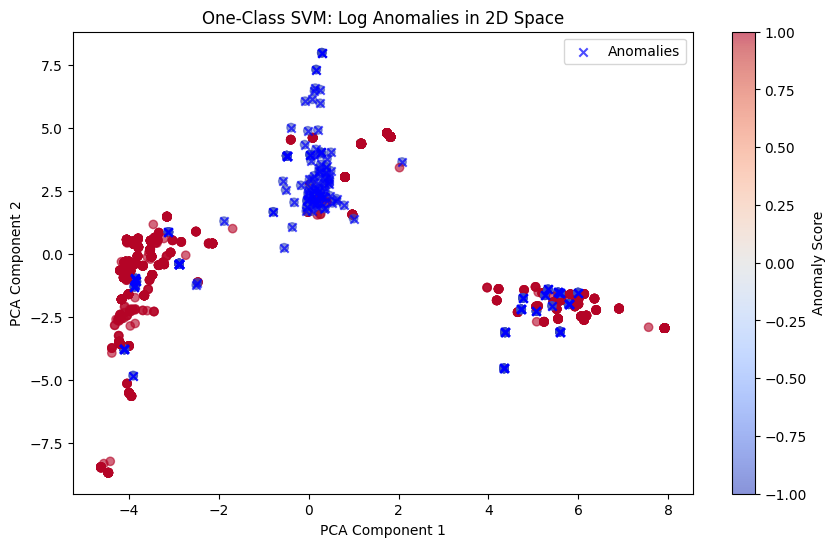

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PCA1"] = X_pca[:, 0]
df["PCA2"] = X_pca[:, 1]

# Plot anomalies
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df["PCA1"], df["PCA2"], c=df["Anomaly_SVM"], cmap="coolwarm", alpha=0.6)
plt.colorbar(scatter, label="Anomaly Score")
plt.scatter(df[df["Anomaly_SVM"] == -1]["PCA1"], df[df["Anomaly_SVM"] == -1]["PCA2"], 
            color="blue", marker="x", label="Anomalies", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("One-Class SVM: Log Anomalies in 2D Space")
plt.legend()
plt.show()


## Extracting Anomaly Patterns

In [16]:

from collections import Counter
import itertools

# Extract anomalies
anomalies_df = df[df["Anomaly_SVM"] == -1]

# Count frequent anomalous EventIds
anomalous_event_counts = anomalies_df["EventId"].value_counts().head(10)

# Common keywords in anomaly logs
words = list(itertools.chain(*[content.split() for content in anomalies_df["Content"]]))
common_keywords = Counter(words).most_common(15)

anomalous_event_counts, common_keywords


(EventId
 E29    67
 E18    55
 E16    42
 E14    15
 E37     6
 E47     4
 E36     4
 E89     4
 E20     3
 E9      2
 Name: count, dtype: int64,
 [('authentication', 97),
  ('failure;', 97),
  ('logname=', 97),
  ('uid=0', 97),
  ('euid=0', 97),
  ('tty=NODEVssh', 97),
  ('ruser=', 97),
  ('from', 83),
  ('connection', 82),
  ('at', 70),
  ('2005', 68),
  ('user=root', 55),
  ('Jul', 37),
  ('Jun', 31),
  ('63.197.98.106', 23)])

## Save Detected Anomalies

In [17]:

# Save anomalies to CSV
anomalies_df[["LineId", "EventId", "Content"]].to_csv("./anomalies_detected.csv", index=False)
"./anomalies_detected.csv"


'./anomalies_detected.csv'

## Analyze Anomalous Events

In [18]:
import re

# Load anomalies file
file_path = "anomalies_detected.csv"
df = pd.read_csv(file_path)

# Count most frequent anomalous EventIds
event_counts = df["EventId"].value_counts().head(10)
print("Most Frequent Anomalous Events:")
print(event_counts)
print("\n" + "="*50 + "\n")

# Extract words from Content column
words = list(itertools.chain(*[content.split() for content in df["Content"]]))
common_keywords = Counter(words).most_common(15)
print("Common Keywords in Anomalies:")
print(common_keywords)
print("\n" + "="*50 + "\n")

# Detect IP addresses in Content
ip_pattern = r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b'
ip_addresses = list(itertools.chain(*[re.findall(ip_pattern, content) for content in df["Content"]]))
ip_counts = Counter(ip_addresses).most_common(10)
print("Most Frequent IP Addresses in Anomalies:")
print(ip_counts)


Most Frequent Anomalous Events:
EventId
E29    67
E18    55
E16    42
E14    15
E37     6
E47     4
E36     4
E89     4
E20     3
E9      2
Name: count, dtype: int64


Common Keywords in Anomalies:
[('authentication', 97), ('failure;', 97), ('logname=', 97), ('uid=0', 97), ('euid=0', 97), ('tty=NODEVssh', 97), ('ruser=', 97), ('from', 83), ('connection', 82), ('at', 70), ('2005', 68), ('user=root', 55), ('Jul', 37), ('Jun', 31), ('63.197.98.106', 23)]


Most Frequent IP Addresses in Anomalies:
[('163.27.187.39', 30), ('63.197.98.106', 23), ('82.252.162.81', 22), ('82.83.227.67', 12), ('202.181.236.180', 10), ('208.62.55.75', 6), ('218.16.122.48', 5), ('218.55.234.102', 5), ('24.54.76.216', 2), ('83.116.207.11', 2)]
